## Imports

In [2]:
import copy
import glob
import importlib
import itertools
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball
import seaborn as sns
import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import lipiodol_vis as lvis
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config
sns.set(style="ticks")
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
importlib.reload(config)
C = config.Config()
target_dir = "D:\\Lipiodol\\Data"
patients = [basename(fn) for fn in glob.glob(join(target_dir,"*"))]
num_patients = len(patients)

## Pattern analysis

In [383]:
lesion_id = "PK-11C"
importlib.reload(lm)
paths = lm.get_paths(lesion_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, mribl_sub_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

lm.spherize(lesion_id, target_dir)

In [16]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")

master_df.loc[lesion_id,"0=well delineated, 1=infiltrative"]

### Validate HU scale

In [ ]:
valid_blcts = ["BM-02", ""]

In [357]:
LI = []
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    img,D = hf.nii_load(ct24_path)
    M = masks.get_mask(ct24_tumor_mask_path, D, img.shape)[0]
    img = img*M/M.max()
    
    LI.append(filters.threshold_li(img[img > 100]))

In [342]:
np.percentile(LI, 100/3), np.percentile(LI, 200/3)

(159.8438546709155, 215.4651656444234)

In [27]:
#[Alt approach: K-means clustering (2 clusters) + median of peaks: 166.0 HU, 215.1 HU]

### Build DataFrame

In [5]:
pattern_feat_cols = ["lipcoverage_vol%", "high_lip", "rim_lipiodol%", "low_peripheral", "mid_peripheral"]
#["enhancing_vol%", "lipcoverage_vol%", "rim_enhancing%", "rim_lipiodol%", "peripheral_coverage%"]

lipresp_cols = []
for name in itertools.product(["base_", "low_", "mid_", "high_"], ["resp%", "prog%", "bl_enh%", "30d_enh%"]):
    lipresp_cols.append(name[0]+name[1])
    
# resp% is the % of BL enhancing tumor that becomes necrotic within this lipiodol range
# prog% is the % of BL necrotic tumor that becomes enhancing within this lipiodol range
# bl_enh% is the % of tumor within this lipiodol range that is enhancing on BL MR
# 30d_enh% is the % of tumor within this lipiodol range that is enhancing on 30d MR

pattern_df = pd.DataFrame(columns=pattern_feat_cols)
lipresp_df = pd.DataFrame(columns=lipresp_cols)

for name in lipresp_cols:
    df.loc[:,"peripheral_coverage%"]=pd.Series(np.random.randn(len(df)), index=df.index)

In [430]:
importlib.reload(config)
C = config.Config()

In [7]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")
"""lipresp_df = pd.read_excel(C.data_xls_path, "Lip-Resp")
vasc_depo_df = pd.read_excel(C.data_xls_path, "Vascularization-Deposition")
depo_resp_df = pd.read_excel(C.data_xls_path, "Deposition-Response")
vasc_depo_df_binary = pd.read_excel(C.data_xls_path, "Vasc-Depo-binary")
depo_resp_df_binary = pd.read_excel(C.data_xls_path, "Depo-Resp-binary")""";

In [630]:
writer = pd.ExcelWriter(C.data_xls_path)

In [62]:
[basename(fn) for fn in glob.glob(join(target_dir,"*"))].index('PK-02')

27

### Get Patterns

In [ ]:
"D:\Lipiodol\MASTER SOPHIE.xlsx"

In [636]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths

    #core_IV = lm.get_avg_core_intensity(ball_ct24_path, ball_mask_path)
    #pattern_df.loc[lesion_id, "rim_lipiodol%"] = lm.get_rim_coverage(row,
    #                              hf.nii_load(ball_ct24_path)[0], ball_mask_path, max(core_IV,150))
    pattern_df.loc[lesion_id, ["low_peripheral", "mid_peripheral"]] = \
        lm.get_peripheral_coverage(ball_ct24_path, ball_mask_path, [100,150])

In [637]:
exemplars = [x.upper() for x in ["Pk-01a","Pk-03","Pk-08","Pk-11c","Bm-07","Bm-16a","Bm-16b","Bm-19","Bm-21","Bm-24","Bm-25","Bm-37"]]

lesion_id = "PK-11C"
pattern_df.loc[lesion_id] = lm.get_row_entry(lesion_id, target_dir)

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    print(lesion_id)
    pattern_df.loc[lesion_id] = lm.get_row_entry(lesion_id, target_dir)

importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    lips = lm.enhancing_to_nec(lesion_id, target_dir, liplvls)
    lipresp_df.loc[ix] = np.round(np.array(lips)*100,2).flatten()

In [789]:
pattern_df.to_excel(writer, "Patterns")
#lipresp_df.to_excel(writer, "Lip-Resp")
writer.save()

## Correlating Vasc/Lip Deposition

In [4]:
liplvls=[0,100,160,215]#list(range(0,401,10))

In [ ]:
importlib.reload(lm)
vasc_depo_df = pd.DataFrame(columns=np.transpose([[str(L)+"N", str(L)+"V"] for L in liplvls], (1,0)).flatten())
for lesion_id in patients:
    print(lesion_id)
    vasc_depo_df.loc[lesion_id] = lm.vascular_to_deposition(lesion_id, target_dir, liplvls, exclude_small=True)

In [ ]:
importlib.reload(lm)
depo_resp_df = pd.DataFrame(columns=liplvls)
for lesion_id in patients:
    print(lesion_id)
    depo_resp_df.loc[lesion_id] = lm.lip_to_response(lesion_id, target_dir, liplvls, exclude_small=True)

In [892]:
Vdf = vasc_depo_df.dropna()
Rdf = depo_resp_df.dropna()#subset=[100,150,200])

In [884]:
depo_resp_df.loc[master_df["lipcoverage_vol%"] > .85, 0] = np.nan

In [ ]:
((master_df["lipcoverage_vol%"] < .2) & (master_df["rim_lipiodol%"] <= .9) & (master_df["0=well delineated, 1=infiltrative"] == 1)).sum()

## Vascularization subgraphs

In [156]:
df = pd.DataFrame(columns=["Any Coverage", "Low-Mid Coverage", "Low Coverage", "Lesion_id", "Tissue Type", "All",
                       "Tumor Growth", "Tumor Type", "TACE Type", "Homogeneity", "Sparsity", "Rim Presence"])

master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "mrbl"

master_df["enhancing_vol%"] = master_df["enhancing_vol%"].astype(float)
master_df["rim_enhancing%"] = master_df["rim_enhancing%"].astype(float)

In [157]:
def get_row(row, char):
    return [row["%d%s"%(liplvls[1],char)],
            row["%d%s"%(liplvls[1],char)] - row["%d%s"%(liplvls[3],char)],
            row["%d%s"%(liplvls[1],char)] - row["%d%s"%(liplvls[2],char)]]

In [158]:
importlib.reload(lvis)
ix = 0
for lesion_id, row in Vdf.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    
    df.loc[ix] = get_row(row,"N") + [lesion_id, "Necrosis"] + const
    df.loc[ix+1] = get_row(row,"V") + [lesion_id, "Viable"] + const
    ix += 2

In [239]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    """topbar = plt.Rectangle((0,0),1,1,fc="#C3C3C3", edgecolor = 'none')
    midbar = plt.Rectangle((0,0),1,1,fc='#A3A3A3',  edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='#737373',  edgecolor = 'none')
    l = plt.legend([bottombar, midbar, topbar],
                   ['High Lipiodol', 'Medium Lipiodol', 'Low Lipiodol'], loc='upper left')#, ncol=2, prop={'size':16})
    l.draw_frame(False)"""
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, width=5, dpi=150, pad_inches=0, transparent=True)
    plt.close()

In [224]:
kwargs = {"x":"Tissue Type", "data":df, "size":3, "aspect":.8, "kind":"bar", "ci":None, "legend":False}

In [243]:
g1 = sns.factorplot(y="Any Coverage", color="#D3D3D3", **kwargs)
set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Mean1.png"))
g2 = sns.factorplot(y="Low-Mid Coverage", color="#939393", **kwargs)
set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Mean2.png"))
g3 = sns.factorplot(y="Low Coverage", color="#333333", **kwargs)
set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Mean3.png"))

for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:

    order = get_actual_order(category, df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "%s3.png" % category))

In [244]:
focal_df = df.dropna(subset=["Tumor Growth"])
focal_df = focal_df[focal_df["Tumor Growth"].str.contains("Focal")]
for ix, row in focal_df.iterrows():
    focal_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Focal")
    focal_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Focal")
kwargs["data"] = focal_df

for category, order in [("Tumor Type", None), ("TACE Type", ["Selective", "Lobar"]),
                        ("Homogeneity", ["Homo", "Hetero"]), ("Sparsity", ["Sparse", "Non"]),
                        ("Rim Presence", ["Rim", "Non"])]:
    
    order = get_actual_order(category, focal_df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Focal_%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Focal_%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Focal_%s3.png" % category))

In [245]:
infil_df = df.dropna(subset=["Tumor Growth"])
infil_df = infil_df[infil_df["Tumor Growth"].str.contains("Infiltrative")]
for ix, row in infil_df.iterrows():
    infil_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Infiltrative")
    infil_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Infiltrative")
kwargs["data"] = infil_df

for category, order in [("Tumor Type", None), ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    
    order = get_actual_order(category, infil_df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Infil_%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Infil_%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Infil_%s3.png" % category))

## Response subgraphs

In [899]:
df = pd.DataFrame(columns=["Response", "Lesion_id", "Lipiodol Deposition",
                       "Tumor Growth", "Tumor Type", "TACE Type", "Homogeneity", "Sparsity", "Rim Presence"])

master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "ct24"

master_df["lipcoverage_vol%"] = master_df["lipcoverage_vol%"].astype(float)
master_df["high_lip"] = master_df["high_lip"].astype(float)
master_df["rim_lipiodol%"] = master_df["rim_lipiodol%"].astype(float)
master_df["low_peripheral"] = master_df["low_peripheral"].astype(float)
master_df["mid_peripheral"] = master_df["mid_peripheral"].astype(float)

master_df = master_df.join(Rdf, how='inner')

### qEASL vs peripheral deposition

In [749]:
master_df = master_df[master_df['selective=0']==0]

In [707]:
importlib.reload(lm)
for lesion_id, row in master_df.iterrows():
    master_df.loc[lesion_id, "qEASL"] = lm.get_qEASL(lesion_id, target_dir)

In [708]:
master_df["low_peripheral"] = master_df["low_peripheral"].astype(float)
master_df["mid_peripheral"] = master_df["mid_peripheral"].astype(float)

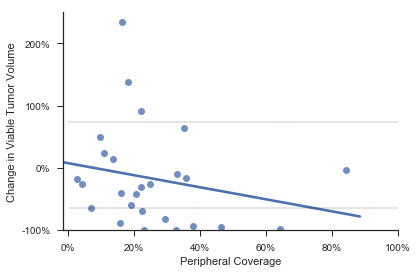

In [756]:
g=sns.regplot(x=master_df["low_peripheral"], y=master_df["qEASL"], ci=None)
g.set_ylabel("Change in Viable Tumor Volume")
g.set_xlabel("Peripheral Coverage")
g.set_ylim([-1,2.5]);
g.set_yticks([-1,0,1,2]);
g.set_yticklabels(["-100%","0%","100%","200%"]);
g.set_xticks([0,.2,.4,.6,.8,1.]);
g.set_xticklabels(["0%","20%", "40%", "60%", "80%", "100%"]);
plt.plot(np.linspace(0,100,1000), [-.65]*1000, 'k--', lw=.3)
plt.plot(np.linspace(0,100,1000), [.73]*1000, 'k--', lw=.3)
sns.despine(top=True, right=True)

In [ ]:
g=sns.factorplot(x="low_peripheral", y="qEASL", hue="selective=0", data=master_df, join=False)
g.ax.set_ylabel("Change in Viable Tumor Volume")
g.ax.set_xlabel("Peripheral Coverage")
g.ax.set_ylim([-1,2.5]);
g.ax.set_yticks([-1,0,1,2]);
g.ax.set_yticklabels(["-100%","0%","100%","200%"]);
g.ax.set_xticks([0,.2,.4,.6,.8,1.]);
g.ax.set_xticklabels(["0%","20%", "40%", "60%", "80%", "100%"]);
plt.plot(np.linspace(0,100,1000), [-.65]*1000, 'k--', lw=.3)
plt.plot(np.linspace(0,100,1000), [.73]*1000, 'k--', lw=.3)
sns.despine(top=True, right=True)

In [ ]:
g=sns.regplot(x=master_df["mid_peripheral"], y=master_df["qEASL"])
g.set_ylabel("% change in viable tumor volume")
g.set_xlabel("% peripheral coverage (150 HU)")

In [589]:
#full_df = Rdf.join(master_df)
#full_df[(full_df["lipcoverage_vol%"] < .25) & (full_df["high_lip"] < .1)]

### main analysis

In [900]:
importlib.reload(lvis)
ix = 0
for lesion_id, row in Rdf.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    for i in range(4):
        df.loc[ix+i] = [row[liplvls[i]], lesion_id, ["None", "Low", "Medium", "High"][i]] + const
    ix += 4

df = df[df["Lesion_id"] != "BM-26"]
df = df[df["Lesion_id"] != "BM-19"]

In [895]:
kwargs = {"x":"Lipiodol Deposition", "y":"Response", "data":df, "size":3, "ci":None,
          "markers":["s", "o", "^"], "legend":False}

In [896]:
def set_g(g, save_path):
    g.set(yticks=[0,.2,.4,.6,.8,1.], ylim=(0.,1.));
    g.ax.set_yticklabels(["0%","20%", "40%", "60%", "80%", "100%"]);
    g.ax.set_xlabel("")
    g.ax.set_ylabel("")
    #g.ax.tick_params('y',width=0)
    #sns.despine(bottom=True)
    #g.fig.tight_layout(w_pad=1)
    plt.legend(loc='lower left');
    g.fig.subplots_adjust(left=0.2)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, dpi=1000, pad_inches=0, transparent=True)
    plt.close()

In [897]:
def get_actual_order(category, df, order):
    if order is None:
        return None
    
    vals = np.unique(df.dropna(subset=[category])[category].values)
    new_order=[]
    for o in order:
        new_order.append([v for v in vals if v.startswith(o)][0])
        
    return new_order

In [870]:
for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    g = sns.factorplot(hue=category, hue_order=get_actual_order(category, df, order), **kwargs)
    set_g(g, join(C.fig_dir, "Deposition figures", "%s.png" % category));

all_df = copy.deepcopy(df)

In [901]:
focal_df = df.dropna(subset=["Tumor Growth"])
focal_df = focal_df[focal_df["Tumor Growth"].str.contains("Focal")]
for ix, row in focal_df.iterrows():
    focal_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Focal")
    focal_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Focal")
kwargs["data"] = focal_df

for category, order in [("Tumor Type", None), ("TACE Type", ["Selective", "Lobar"]),
                        ("Sparsity", ["Sparse", "Non"]), ("Rim Presence", ["Rim", "Non"])]:
    g = sns.factorplot(hue=category, hue_order=get_actual_order(category, focal_df, order), **kwargs)
    
    set_g(g, join(C.fig_dir, "Deposition figures", "Focal_%s.png" % category));
    
#for category, order in [("Homogeneity", ["Homo", "Hetero"])]:
#    g = sns.factorplot(hue=category, hue_order=get_actual_order(category, focal_df, order), **kwargs)
#    set_g(g, join(C.fig_dir, "Deposition figures", "Focal_%s.png" % category));

In [541]:
infil_df = df.dropna(subset=["Tumor Growth"])
infil_df = infil_df[infil_df["Tumor Growth"].str.contains("Infiltrative")]
for ix, row in infil_df.iterrows():
    infil_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Infiltrative")
    infil_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Infiltrative")
kwargs["data"] = infil_df

for category, order in [("Tumor Type", None), ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    g = sns.factorplot(hue=category, hue_order=get_actual_order(category, infil_df, order), **kwargs)
    set_g(g, join(C.fig_dir, "Deposition figures", "Infil_%s.png" % category));

In [ ]:
## print(len(Rdf))
MEAN=Rdf.mean().values

In [320]:
#well delineated
print(len(Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0]))
FOCAL=Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0].mean().values

23


[1-df[i].mean() for i in liplvls]

[x/(1-x) for x in [0.47604184262689564,
 0.3884550297888517,
 0.3352322775428981,
 0.2986988994268489]]

In [ ]:
[1-df[i].mean() for i in liplvls]

In [ ]:
print([df[i].mean() for i in liplvls])

print(np.nanmean(depo_resp_df[0]),
np.nanmean(depo_resp_df[100]),
np.nanmean(depo_resp_df[150]),
np.nanmean(depo_resp_df[200]))

### Ground truth patterns

In [ ]:
pattern_gtruth_df = pd.read_excel(r"D:\Lipiodol\Results\Lipiodol Patterns.xlsx", index_col=0)

In [ ]:
joint_df = pd.concat([vasc_depo_df, pattern_gtruth_df], axis=1, join='inner')

In [ ]:
joint_df.columns

In [ ]:
DF=joint_df.dropna(subset=["heterogeneous"], axis=0)
subset_df = DF.loc[DF["heterogeneous"].str.contains("yes"), liplvls+["heterogeneous"]]
#subset_df = DF.loc[DF["penumbra/margin"]!="no", liplvls+["penumbra/margin"]]
subset_df

In [ ]:
subset_df.index

In [ ]:
rim = 

RIM: "BM-07", "BM-30", "BM-32", "BM-37"
Homogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Heterogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Central deposition: 'BM-18', 'BM-23', 'BM-25', 'BM-31', 'BM-32', 'BM-39', 'PK-03', 'PK-08'
Central recess: 'BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'
Margin: 'BM-30', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-03', 'PK-05'

In [ ]:
len(['BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'])

In [ ]:
len(subset_df)

In [ ]:
subset_df = joint_df.loc[['BM-01', 'BM-02', 'BM-03', 'BM-05', 'BM-06', 'BM-07', 'BM-09', 'BM-10',
       'BM-12', 'BM-19', 'BM-23', 'BM-24', 'BM-26', 'BM-27', 'BM-29', 'BM-30',
       'BM-31', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-05', 'PK-07',
       'PK-08'], [0,1,2,3]]
subset_df

In [119]:
#subset_df.mean().values
subset_df.dropna().mean().values

array([0.49861879, 0.54283119, 0.60239339, 0.64819033])

In [47]:
print(np.mean(subset_df[150]), np.mean(subset_df[200]))

0.4725199969765699 0.7846028172462818


In [514]:
vasc_depo_df.to_excel(writer, "Vascularization-Deposition")
depo_resp_df.to_excel(writer, "Deposition-Response")
writer.save()

In [ ]:
vasc_depo_df

In [515]:
liplvls=[0,100]#,250,300]#list(range(0,401,10))

In [516]:
importlib.reload(lm)
vasc_depo_df_binary = pd.DataFrame(columns=liplvls)
for lesion_id in lipresp_df.index:
    vasc_depo_df_binary.loc[lesion_id] = lm.vascular_to_deposition(lesion_id, target_dir, liplvls, exclude_small=True)

In [517]:
depo_resp_df_binary = pd.DataFrame(columns=liplvls)
for lesion_id in lipresp_df.index:
    depo_resp_df_binary.loc[lesion_id] = lm.lip_to_response(lesion_id, target_dir, liplvls, exclude_small=False)

In [518]:
vasc_depo_df_binary.to_excel(writer, "Vasc-Depo-binary")
depo_resp_df_binary.to_excel(writer, "Depo-Resp-binary")
writer.save()

### T-Test

In [522]:
scipy.stats.ttest_1samp((vasc_depo_df_binary[100]-vasc_depo_df_binary[0]).dropna(), 0)

Ttest_1sampResult(statistic=2.3802691829515616, pvalue=0.025971980984010247)

In [523]:
scipy.stats.ttest_1samp((vasc_depo_df[150]-vasc_depo_df[100]).dropna(), 0)

Ttest_1sampResult(statistic=2.428121152144739, pvalue=0.024249353783670376)

In [524]:
scipy.stats.ttest_1samp((vasc_depo_df[200]-vasc_depo_df[150]).dropna(), 0)

Ttest_1sampResult(statistic=2.7092952234597485, pvalue=0.013907459079104805)

In [525]:
scipy.stats.ttest_1samp((depo_resp_df_binary[100]-depo_resp_df_binary[0]).dropna(), 0)

Ttest_1sampResult(statistic=3.492729013676934, pvalue=0.0015538515664505574)

In [533]:
scipy.stats.ttest_1samp((depo_resp_df[150]-depo_resp_df[100]).dropna(), 0)

Ttest_1sampResult(statistic=1.2250109889424856, pvalue=0.2348033858355313)

In [534]:
scipy.stats.ttest_1samp((depo_resp_df[200]-depo_resp_df[150]).dropna(), 0)

Ttest_1sampResult(statistic=2.800068905160147, pvalue=0.011421953792365588)

## Create Ranked DICOMs

In [ ]:
importlib.reload(lvis)
lvis.write_ranked_imgs(pattern_df, target_dir, "lipcoverage_vol%", "ct24_path", join(C.ranking_dir, "coverage_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
lvis.write_ranked_imgs(pattern_df, target_dir, "rim_lipiodol%", "ct24_path", join(C.ranking_dir, "rim_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
lm.write_ranked_imgs(pattern_df, target_dir, "peripheral_coverage%", "ct24_path", join(C.ranking_dir, "penumbra_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")

In [260]:
importlib.reload(lvis)
lvis.write_ranked_imgs(pattern_df, target_dir, "enhancing_vol%", "mribl_sub_path", join(C.ranking_dir, "coverage_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")
lvis.write_ranked_imgs(pattern_df, target_dir, "rim_enhancing%", "mribl_sub_path", join(C.ranking_dir, "rim_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")

In [141]:
masks.create_dcm_with_masks(ball_ct24_path, [ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path],
                            save_dir, overwrite=True, window="ct")

## Tumor Mask Screenshots

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths

    lm.draw_unreg_fig(mribl_art_path, mribl_tumor_mask_path, join(C.png_dir, lesion_id, "BL MR"), 'b', 'mr')
    lm.draw_unreg_fig(mri30d_art_path, mri30d_tumor_mask_path, join(C.png_dir, lesion_id, "30d MR"), 'r', 'mr')
    lm.draw_unreg_fig(ct24_path, ct24_tumor_mask_path, join(C.png_dir, lesion_id, "24h CT"), 'g', 'ct')

In [ ]:
lm.draw_reg_fig(ball_mribl_path, ball_mribl_enh_mask_path, join(C.fig_dir, lesion_id, "MRIBL"), 'b', 'mr')
lm.draw_reg_fig(ball_mri30d_path, ball_mri30d_enh_mask_path, "D:\\Lipiodol\\Figures\\MRI30d", 'r', 'mr')
lm.draw_reg_fig(ball_ct24_path, ball_highlip_mask_path, "D:\\Lipiodol\\Figures\\Lip", 'g', 'ct')

In [ ]:
# Figure for 24h CT
img,_ = hf.nii_load(ball_ct24_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)

for sl in range(img.shape[-1]//4,img.shape[-1]*3//4,img.shape[-1]//12):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    FU=plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.contourf(fumask[:,:,sl], colors=[(0,0,0,0)]*6+[(1,0,0,.2)]) #look at the length of FU.allsegs
    plt.contourf(blmask[:,:,sl], colors=[(0,0,0,0)]*6+[(0,0,1,.2)])
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

### DICOMs for HU threshold validation

In [381]:
importlib.reload(masks)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    lowlip_mask_path = join(mask_dir, "low_lipiodol")

    masks.create_dcm_with_multimask(ct24_path, [highlip_mask_path, midlip_mask_path, lowlip_mask_path],
                                    join(C.fig_dir, "HU threshold validation", lesion_id), overwrite=True, padding=0, window="ct")

### Binary masks for sphering figure

In [ ]:
importlib.reload(hf)
liver_dir = join(C.fig_dir, "sphering figure", "liver binary mask")
tumor_dir = join(C.fig_dir, "sphering figure", "tumor binary mask")
if not exists(liver_dir):
    os.makedirs(liver_dir)
if not exists(tumor_dir):
    os.makedirs(tumor_dir)
                
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    if False:
        M = hf.crop_nonzero(masks.get_mask(mribl_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')

        M = hf.crop_nonzero(masks.get_mask(ct24_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

        M = hf.crop_nonzero(masks.get_mask(mri30d_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mribl_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')
                
    M = hf.crop_nonzero(masks.get_mask(ct24_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

In [ ]:
importlib.reload(hf)
liver_dir = join(C.fig_dir, "sphering figure", "liver with mask")
tumor_dir = join(C.fig_dir, "sphering figure", "tumor with mask")
if not exists(liver_dir):
    os.makedirs(liver_dir)
if not exists(tumor_dir):
    os.makedirs(tumor_dir)
                
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    M = hf.crop_nonzero(masks.get_mask(mribl_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(ct24_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mribl_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')
                
    M = hf.crop_nonzero(masks.get_mask(ct24_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

In [ ]:
M = hf.crop_nonzero(masks.get_mask(ball_mask_path)[0], pad=5)[0]
plt.imshow(M[:,:,M.shape[-1]//2+40], cmap='gray')
plt.axis('off')
plt.savefig("D:\\ball.png", dpi=100, bbox_inches='tight')

## Extra

IVs = get_intensity_section(ball_ct24_path, ball_mask_path, params)
            if highest_I_V < I_V:
                best_params = params
                highest_I_V = I_V
                print(best_params)
theta1_best, phi1_best, dtheta_best, dz_best = best_params

In [ ]:
ball_IV = get_avg_ball_intensity(ball_ct24_path, ball_mask_path)
core_IV = get_avg_core_intensity(ball_ct24_path, ball_mask_path)

In [303]:
ball_IV, core_IV

(197.83461276161094, 209.89937589866474)

In [ ]:
importlib.reload(lm)
IVs = lm.calc_intensity_shells_angles(hf.nii_load(ball_ct24_path)[0], ball_mask_path)
IVs[IVs==0] = np.nan

samples = lm.fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(IVs.shape[-1]):
    print(np.nanmean(IVs[s0,s1,i]))

In [388]:
loopIVs = np.tile(IVs[:-1,:-1,:], (2,2,1))
loopIVs[180:,:,:] = np.nan

In [ ]:
for dtheta in range(30,180,20):
    print(dtheta)
    best_IV = core_IV
    worst_IV = core_IV
    for theta in range(0,180,20):
        for phi in range(180,480,20):
            for shell1 in range(4):
                for shell2 in range(shell1+1,5):
                    IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, shell1:shell2])
                    params = theta, phi % 360, shell1, shell2
                    if best_IV < IV:
                        best_params = params
                        best_IV = IV
                        
            IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, :5])
            params = theta, phi % 360
            if worst_IV > IV:
                worst_params = params
                worst_IV = IV
                
    print(best_params, round(best_IV,1))
    print(worst_params, round(worst_IV,1))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mribl_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mri30d_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
enhmask_density =

In [ ]:
conv_rate = np.zeros((181,360))